In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.vector import dynamicsymbols
from sympy import symbols, cos, sin, diff, sqrt, init_printing, latex, Symbol, Eq, solve, lambdify
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
#plt.rcParams["animation.html"] = "jshtml"

# Make printouts look nicer
latexReplaceRules = {
    r'{\left(t \right)}':r' ',
    r'\frac{d}{d t}':r'\dot',
    r'\frac{d^{2}}{d t^{2}}':r'\ddot',
}
def latexNew(expr,**kwargs):
    retStr = latex(expr,**kwargs)
    for _,__ in latexReplaceRules.items():
        retStr = retStr.replace(_,__)
    return retStr
init_printing(latex_printer=latexNew)

In [22]:
#can do constants w symbols. w variables, do dynamic symbols

#constants 
G, M, omega, me, ma, f, mu, a, tau = symbols(r"G, M_s, \Omega, m_e, m_a, f, \mu, a, \tau", real=True)

t=Symbol('t')

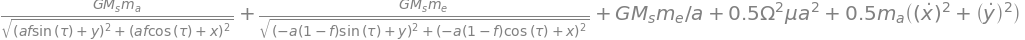

In [23]:
#degrees of freedom

x, y = dynamicsymbols("x, y", real=True) #add r if need to add slash
x_dot=x.diff()
y_dot=y.diff()

L= 0.5*ma*(x_dot**2+y_dot**2) + 0.5*mu*a**2 *omega**2 + G *M*me/a + G*M*ma/sqrt((x+(f*a*cos(omega*t)))**2+(y+f*a*sin(omega*t))**2)+ G*M*me/sqrt((x-((1-f)*a*cos(omega*t)))**2+(y-(1-f)*a*sin(omega*t))**2)

L=L.subs(omega*t, tau) #this is the nondimensionalization step w/ tau=t*omega 
L

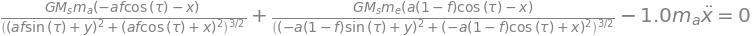

In [24]:
x_derivative = L.diff(x)
x_dot_derivative = L.diff(x_dot)
x_dot_second_derivative = x_dot_derivative.diff(t)

# Euler-Lagrange Equation for x 
ELx = Eq(x_derivative- x_dot_second_derivative, 0)
ELx

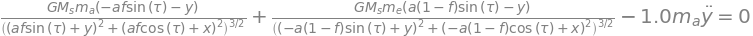

In [25]:
y_derivative = L.diff(y)
y_dot_derivative = L.diff(y_dot)
y_dot_second_derivative = y_dot_derivative.diff(t)

# Euler-Lagrange Equation for y
ELy = Eq(y_derivative- y_dot_second_derivative, 0)

ELy

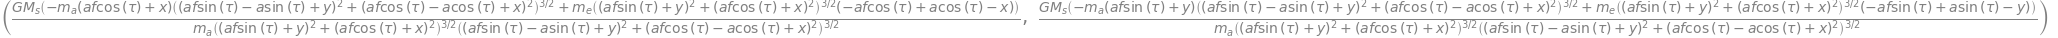

In [26]:
# Isolating x & y double dot

x_doubledot= solve(ELx, x_dot.diff(t))[0] 
y_doubledot= solve(ELy, y_dot.diff(t))[0] #[0] to turn to not list, since gives list of solutions, but there's only 1 solution

x_doubledot, y_doubledot

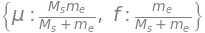

In [27]:
ELsubs = {
    mu: me*M/(M+me),
    f: me/(M+me),
}

ELsubs

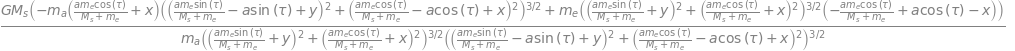

In [28]:
Test=x_doubledot.subs(ELsubs)

Test

In [28]:
# lambdify, give eq in terms of variables, gives its inputs, then lets you input the inputs in the expression. So turn symbolic math into python function 

ELsubs = {
    mu: me*M/(M+me),
    f: me/(M+me),
}
gx = lambdify((tau, x, y, ma, M, me, G, a), x_doubledot.subs(ELsubs), 'numpy') # can't print, is function
fy = lambdify([tau, x, y, ma, M, me, G, a], y_doubledot.subs(ELsubs), 'numpy')

def three_body_prob(tau, Y, me, M, ma, G, a): #it looks like Y=x, y, x dot, y dot
    x, w, y, z = Y #separates Y into 4 variables

    x_dot = w
    y_dot = z
    w_dot = gx(tau, x, y, ma, M, me, G, a)
    z_dot = fy(tau, x, y, ma, M, me, G, a)

    return x_dot, w_dot, y_dot, z_dot


In [87]:
#solving the differential equation

#t_eval=t does more intermediate positions

t_eval = np.linspace(0, 100, 1000) #a range, specifies gaps between numbers. linspace gives start, end, jump

initial_conditions= [90, 0, 0, 0] #x initial, y initial, x dot initial, y dot initial
args = (1, 1000, 10, 100, 100) # ma, M, me, G, a

sol = solve_ivp(three_body_prob, (np.min(t_eval), np.max(t_eval)), initial_conditions, args=args, t_eval=t_eval) #in the same order as defined above. Just returns the times you ask for
xa, wa, ya, za = sol.y
t_eval = sol.t

f_sub = ELsubs[f].subs([(M, args[1]), (me, args[0])]).evalf()
a_sub = args[4]

xs = -f_sub * a_sub * np.cos(t_eval)
ys = -f_sub * a_sub * np.sin(t_eval)

xe = (1-f_sub) * a_sub * np.cos(t_eval)
ye = (1-f_sub) * a_sub * np.sin(t_eval)

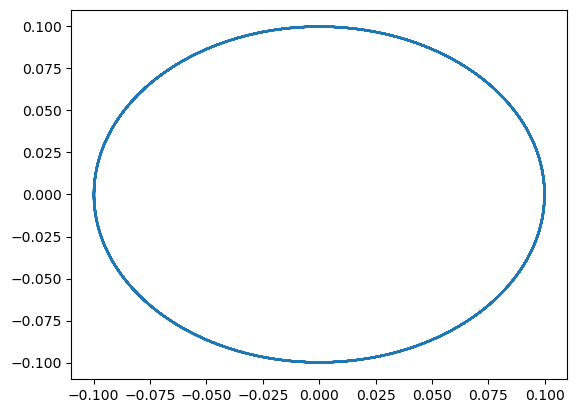

In [88]:
plt.plot(xs, ys)

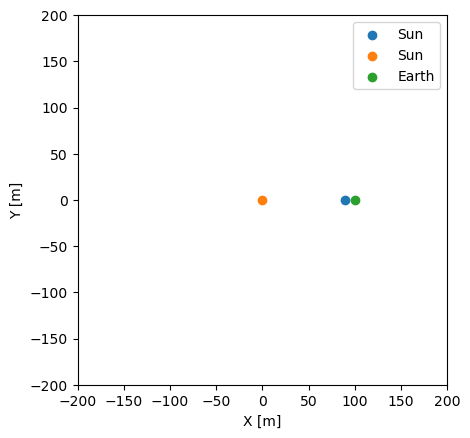

In [ ]:
fig, ax = plt.subplots()

# asteroid_line, = ax.plot(xa[0], ya[0], label="Asteroid")
asteroid_line = ax.scatter(xa[0], ya[0], label="Sun")
sun_line = ax.scatter(xs[0], ys[0], label="Sun")
earth_line = ax.scatter(xe[0], ye[0], label="Earth")

# axis_lim = args[0] * 1.1
axis_lim = 200

ax.set(xlim=[-axis_lim, axis_lim], ylim=[-axis_lim, axis_lim], xlabel='X [m]', ylabel='Y [m]')
ax.set_aspect("equal")
ax.legend()

def update(frame):
    # for each frame, update the data stored on each artist.
    # asteroid_line.set_data(xa[:frame], ya[:frame])
    asteroid_line.set_offsets(np.stack([xa[frame], ya[frame]]).T)
    sun_line.set_offsets(np.stack([xs[frame], ys[frame]]).T)
    earth_line.set_offsets(np.stack([xe[frame], ye[frame]]).T)

ani = animation.FuncAnimation(fig=fig, func=update, frames=100)#t_eval.shape[0])
ani.save(filename="example.gif", writer="pillow")
# plt.show()
ani

In [ ]:
#On 11-27, I'm gonna try to basically repeat everything above except with the new Lagrangian. So, I just copy that in. 

In [29]:
#can do constants w symbols. w variables, do dynamic symbols

#constants 
d, e, G, M, omega, me, ma, f, mu, a, tau = symbols(r"d, e, G, M_s, \Omega, m_e, m_a, f, \mu, a, \tau", real=True)

t=Symbol('t')

In [30]:
#degrees of freedom
#I changed this to the dimensionless X, Y, and T. 

X, Y = dynamicsymbols("X, Y", real=True) #add r if need to add slash
X_dot=X.diff()
Y_dot=Y.diff()
X_double_dot=X_dot.diff()
Y_double_dot=Y_dot.diff()

# this is a fake lagrangian that I'm too scared to erase L= 0.5*mu*a**2 *omega**2 + 0.5*ma*(x_dot**2+y_dot**2)*omega**2 + 0.5*ma*(x**2+y**2) +ma*omega*(y_dot*x- x_dot*y) + G *M*me/a + G*M*ma/sqrt(y**2 +(x+f*a)**2)+ G*me*ma/sqrt(y**2 +(x-(1-f)*a)**2)


#L=L.subs(omega*t, tau) #this is the nondimensionalization step w/ tau=t*omega 


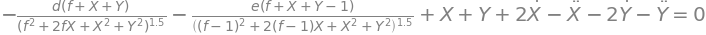

In [31]:
#This should very hopefully solve the coupled differential equations

combined_equationsLHS=X+Y-2*(Y_dot-X_dot) -(X_double_dot + Y_double_dot)-d*(X+Y+f)/(X**2+2*f*X+f**2+Y**2)**1.5 -e*(X+Y-1+f)/(X**2+2*X*(f-1)+(f-1)**2+Y**2)**1.5
#This is what happened when I basically solved the Euler-Lagrange equations and added them together. 
combined_equations = Eq(combined_equationsLHS, 0)
combined_equations

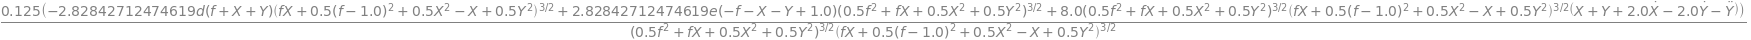

In [32]:
# Hopefully X double dot and Y double dot?
X_doubledot= solve(combined_equations, X_double_dot)[0] 
Y_doubledot= solve(combined_equations, Y_double_dot)[0] 

X_doubledot

In [36]:
# lambdify, give eq in terms of variables, gives its inputs, then lets you input the inputs in the expression. So turn symbolic math into python function 


gx = lambdify((X, Y, d, e, f), X_doubledot, 'numpy') #Before, python solved for X dot dot and Y dot dot. So, this puts that as a function, so we can use it later for our DE. 
fy = lambdify([X, Y, d, e, f], Y_doubledot, 'numpy')

def three_body_prob(tau, Z, d, e, f): #Not sure why we need it, but I added tau back in.
    X, w, Y, z = Z #separates Z into 4 variables, corresponding to X, X dot, Y, Y dot. So...I guess Z is supposed to be a list? 

    X_dot = w
    Y_dot = z
    w_dot = gx(X, Y, d, e, f)
    z_dot = fy(X, Y, d, e, f)

    return X_dot, w_dot, Y_dot, z_dot

In [ ]:
#solving the differential equation

#t_eval=t does more intermediate positions

t_eval = np.linspace(0, 100, 1000) #a range, specifies gaps between numbers. linspace gives start, end, jump. Don't think is necessary, 'cause we don't have time, tho.
#Not really sure what t means, here.... I guess it's tau. So we can maybe multiply by omega later or something to get back to actual time? 


initial_conditions= [90, 0, 0, 0] #x initial, y initial, x dot initial, y dot initial. This is Z!!! 
#args = (1, 1000, 10, 100, 100) # ma, M, me, G, a

args= (10e22, 10e16, 10e-6) #this is just d, e, f, so we can insert this into three_body_prob. 

sol = solve_ivp(three_body_prob, (np.min(t_eval), np.max(t_eval)), initial_conditions, args=args, t_eval=t_eval) #in the same order as defined above. Just returns the times you ask for. Goes like: function, interval, initial conditions, optional arguments
xa, wa, ya, za = sol.y #why is this sol.y? 
t_eval = sol.t

#maybe I'm getting these errors bc the original function is wrong?

f_sub = ELsubs[f].subs([(M, args[1]), (me, args[0])]).evalf()
a_sub = args[4]

xs = -f_sub * a_sub * np.cos(t_eval)
ys = -f_sub * a_sub * np.sin(t_eval)

xe = (1-f_sub) * a_sub * np.cos(t_eval)
ye = (1-f_sub) * a_sub * np.sin(t_eval)

NameError: name 'Derivative' is not defined